## Introduzione

I **sistemi di raccomandazione** sono dei sistemi software che permettono di predire le preferenze di un utente basandoci sui dati raccolti in passato su di esso.  
A differenza dei sistemi tradizionali, essi possono predire il gradimento dell'utente anche per oggetti meno popolari, catturando il cosiddetto fenomeno **long-tail**.  
Un sistema di raccomandazione conserva le valutazioni in una matrice, chiamata **matrice di utilità** $M$, avente grandezza $|U| \times |I|$, dove:  
- $U$ è l'insieme degli utenti
- $I$ è l'insieme degli item

L'insieme delle celle della matrice $M$, composto da tutte le possibili coppie $(u, i)$ dove $u \in U$ e $i \in I$, contiene le valutazioni degli utenti sugli item.  
Le valutazioni possono essere definite in diversi spazi, come l'insieme dei numeri reali $R$ o l'insieme dei numeri binari $[0, 1]$.

I sistemi di raccomandazione possono dividersi in due categorie.  
La prima categoria contiene i sistemi di raccomandazione **content-based** che utilizzano le informazioni sulle proprietà degli item per generare un profilo di ogni item. Inoltre, mantengono un profilo dell'utente che riflette le sue preferenze in base alle proprietà degli item che ha già valutato in passato. Per suggerire nuovi item all'utente, il sistema calcola la similarità tra il profilo dell'utente e quello degli item presenti ancora da valutare, e suggerisce gli item che presentano la maggiore somiglianza. Le predizioni sugli item vengono quindi effettuate sulla base della corrispondenza tra le proprietà degli item suggeriti e il profilo dell'utente.  
La seconda categoria contiene i sistemi **collaborative-filtering** che utilizzano le informazioni sulle interazioni passate degli utenti con gli item per generare raccomandazioni personalizzate. In particolare, questi sistemi possono essere basati sulla similarità tra gli utenti (user-based collaborative filtering) o tra gli item (item-based collaborative filtering).  
Nel caso dell'user-based collaborative filtering, le predizioni sugli item per un utente vengono fatte basandosi sull'esperienza degli altri utenti simili a lui. Questo viene fatto calcolando la similarità tra il profilo di gradimento dell'utente corrente e quello degli altri utenti, e utilizzando queste informazioni per generare una lista di raccomandazioni personalizzate.  
Nel caso dell'item-based collaborative filtering, invece, le predizioni sugli item vengono fatte basandosi sulla similarità tra gli item presenti nel catalogo. Il sistema cerca gli item che sono stati graditi da utenti simili a quello corrente, e utilizza queste informazioni per generare una lista di raccomandazioni personalizzate.  
In entrambi i casi, i sistemi di raccomandazione collaborative filtering sfruttano la conoscenza delle preferenze degli utenti per generare raccomandazioni personalizzate, senza la necessità di conoscere dettagliate informazioni sulle proprietà degli item.

## Obiettivo
Creeremo diversi sistemi di raccomandazione per confrontarne le prestazioni. Oltre ai sistemi classici, useremo anche due sistemi personalizzati:
- un sistema che normalizza le valutazioni degli item secondo una media pesata utilizzando il timestamp associato ad esse.
- un sistema che utilizza delle valutazioni binarie invece delle valutazioni reali.  

Useremo la versione ridotta di questo [dataset](https://grouplens.org/datasets/movielens/latest/) per generare i sistemi di raccomandazione. Al suo interno sono presenti due file in formato `.csv`:  
- `movies.csv`: contiene l'elenco dei film, con i campi `movieId`, `title` e `genres`.  
- `ratings.csv`: contiene l'elenco delle valutazione relative agli utenti, con i campi `userId`, `movieId`, `rating`, `timestamp`. 


## Preparazione dell'ambiente
All'interno del nostro progetto, useremo diverse librerie:  
- [`pandas`](https://pandas.pydata.org/), permette di leggere e manipolare i dati in formato `.csv`.
- [`surprise`](https://surpriselib.com/), permette la creazione e l'addestramento dei sistemi di raccomandazione in Python.  
- [`matplotlib`](https://matplotlib.org/), permette la creazione di grafici e la loro visualizzazione.
- [`numpy`](https://numpy.org/), permette di utilizzare array multidimensionali e di eseguire operazioni matematiche su di essi.
- [`scipy`](https://www.scipy.org/), permette di eseguire operazioni matematiche su array multidimensionali. Lo useremo per effettuare alcuni test statistici.

Iniziamo leggendo i file `.csv` sopra elencati ed organizziamoli in due `DataFrame` di `pandas`.   
I data frame ci consentono di organizzare i dati in tabelle, dove ogni colonna rappresenta un attributo e ogni riga rappresenta un record, rendendo più semplice la lettura e la manipolazione dei dati.  
La funzione `read_csv()` ci permette di leggere i file, creare i data frame partendo da questi ultimi ed assegnarli alle variabili `movie_dataset` e `rating_dataset`.

In [29]:
import os

import pandas as pd

movie_dataset_path = os.path.join(os.getcwd(), 'movie-dataset', 'movies.csv')
rating_dataset_path = os.path.join(os.getcwd(), 'movie-dataset', 'ratings.csv')

movie_dataset = pd.read_csv(movie_dataset_path, sep=',', engine='python')
rating_dataset = pd.read_csv(rating_dataset_path, sep=',', engine='python')

Una volta caricati i dati, verifichiamone l'**integrità**.  
L'integrità dei dati è essenziale per garantire l'affidabilità dei risultati dell'analisi.  
La presenza di righe con dati incompleti, come i valori `NaN`, potrebbero influenzare negativamente i risultati.  
Per scartare i dati incompleti, possiamo utilizzare la funzione `dropna()`, che restituisce un nuovo data frame partendo da quello originale, eliminando le righe che contengono valori `NaN`.

In [30]:
movie_dataset = movie_dataset.dropna()
rating_dataset = rating_dataset.dropna()

Dopo aver verificato l'integrità dei dati, è necessario organizzare i dati in delle strutture utilizzabili dai sistemi di raccomandazione.  
La libreria `surprise` organizza i dati in una struttura chiamata `Dataset`, formata da triple `(user, item, rating)`.  
Per poter strutturare i dati in questo modo, utilizziamo la funzione la funzione `load_from_df()` passando in input il data frame contenente le valutazioni degli utenti e un oggetto `Reader()` per specificare il range di definizione delle valutazioni.

In [31]:
from surprise import Dataset, Reader

all_values: list[float] = rating_dataset['rating'].unique().tolist()
all_values.sort()
min_value: float = all_values[0]
max_value: float = all_values[-1]

elaborated_data = Dataset.load_from_df(rating_dataset[['userId', 'movieId', 'rating']], Reader(rating_scale=(min_value, max_value)))

print('Min value of rating:', min_value)
print('Max value of rating:', max_value)
print('Possible values assumed by ratings:', all_values)

Min value of rating: 0.5
Max value of rating: 5.0
Possible values assumed by ratings: [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


Da una prima osservazione dal data set, possiamo notare che le valutazioni degli utenti sono comprese tra 0.5 e 5.0.  
Inoltre, i valori sono definiti con un passo di 0.5. Ciò significa che una valutazione non potrà assumere, ad esempio, il valore 3.7.

## Analisi dei dati

Dal data frame delle valutazioni, possiamo calcolare alcuni proprietà specifiche per ogni utente.  
Creiamo dunque il data frame `users_dataset` che sarà popolato da alcune informazioni ottenute dal data frame `rating_dataset`, quali:
- `mean`: la media aritmetica dei rating dell'utente
- `weighted_mean`: la media pesata dei rating dell'utente, utilizzando il timestamp come peso. Durante il calcolo, normalizziamo i timestamp in modo che siano compresi in un intervallo definito fra 0.5 e 1.5.
- `mean_diff`: la differenza fra la media aritmetica e la media pesata dell'utente
- `time_diff`: la differenza fra il timestamp della prima valutazione dell'utente e il timestamp dell'ultima valutazione dell'utente.

Calcoliamo dunque queste informazioni per ogni utente e popoliamo il data frame `users_dataset`.

In [32]:
import numpy as np

users_list = rating_dataset['userId'].unique().tolist()
users_dataset = pd.DataFrame(columns=['mean', 'weighted_mean', 'mean_diff', 'time_diff'])
users_dataset.index.name = 'userId'

def map_range(x: float, in_min: float, in_max: float, out_min = 0.5, out_max = 1.5) -> float:
    return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min

for user in users_list:
    single_ratings = rating_dataset[rating_dataset['userId'] == user]
    single_last_timestamp = single_ratings['timestamp'].max()
    single_first_timestamp = single_ratings['timestamp'].min()
    user_ratings = single_ratings['rating'].tolist()
    user_timestamps = list(map(lambda x: map_range(x, single_first_timestamp, single_last_timestamp), single_ratings['timestamp'].tolist()))
    user_mean = np.mean(user_ratings)
    user_weighted_mean = np.average(user_ratings, weights=user_timestamps)
    user_mean_diff = abs(user_mean - user_weighted_mean)
    user_time_diff = single_last_timestamp - single_first_timestamp
    users_dataset = pd.concat([users_dataset, pd.DataFrame([[user_mean, user_weighted_mean, user_mean_diff, user_time_diff]], columns=['mean', 'weighted_mean', 'mean_diff', 'time_diff'], index=[user])])
    users_dataset.index.name = 'userId'
    
users_dataset

,mean,weighted_mean,mean_diff,time_diff
userId,,,,
1,4.366379,4.363284,0.003095,739163
2,3.948276,4.007142,0.058866,505
3,2.435897,2.287578,0.148320,970
4,3.555556,3.480049,0.075507,62496114
5,3.636364,3.667064,0.030700,590
...,...,...,...,...
606,3.657399,3.640449,0.016951,197231731
607,3.786096,3.710835,0.075261,34768995
608,3.134176,3.250530,0.116354,72402187


Una volta calcolate queste informazioni, possiamo visualizzarle in dei grafici.  
I primi due grafici mostrano la distribuzione dei valori di `mean` e `weighted_mean` in modo da poter visualizzare eventuali differenze fra le due.

Text(0, 0.5, 'Frequency')

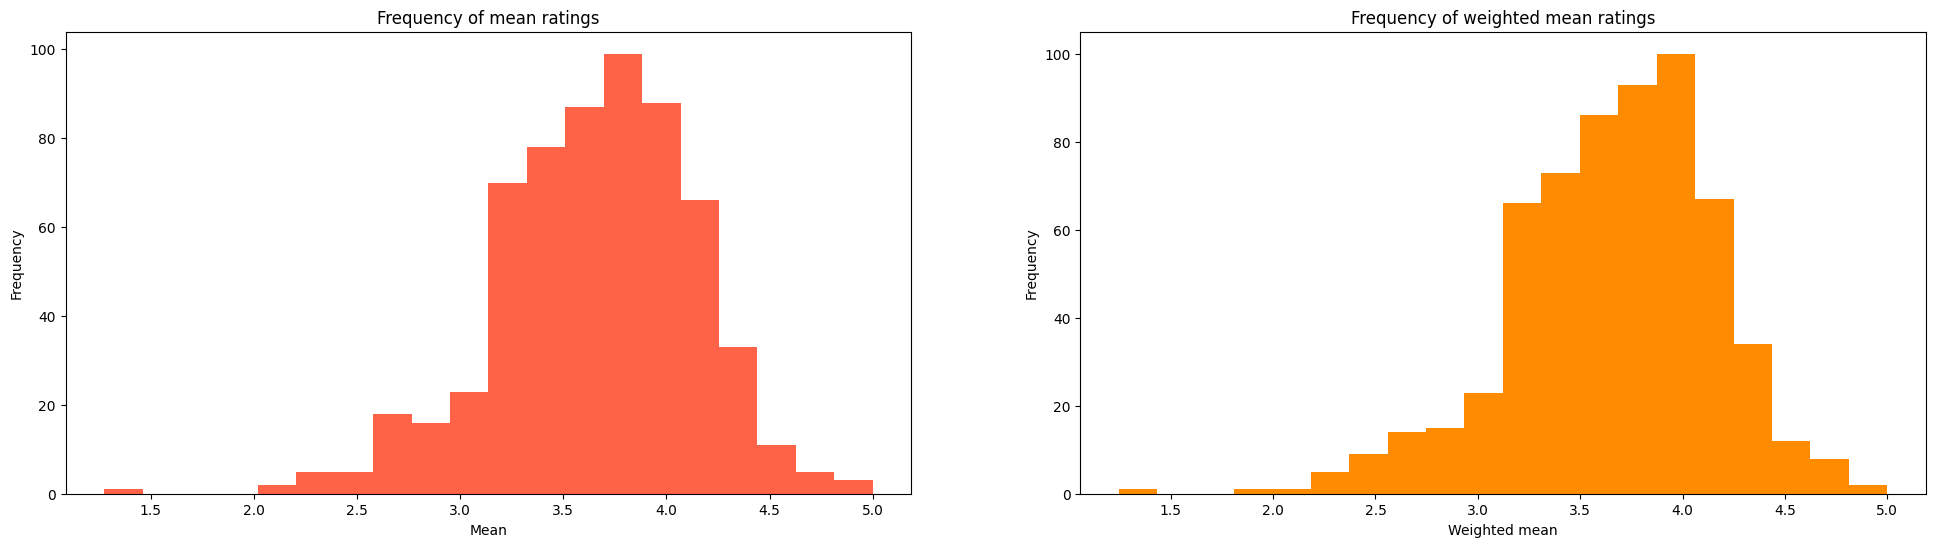

In [33]:
from matplotlib import pyplot as plt

(fig, axis) = plt.subplots(nrows = 1, ncols = 2, figsize=(24, 6))
axis[0].hist(users_dataset['mean'], bins = 20, color = 'tomato')
axis[0].set_title('Frequency of mean ratings')
axis[0].set_xlabel('Mean')
axis[0].set_ylabel('Frequency')
axis[1].hist(users_dataset['weighted_mean'], bins = 20, color = 'darkorange')
axis[1].set_title('Frequency of weighted mean ratings')
axis[1].set_xlabel('Weighted mean')
axis[1].set_ylabel('Frequency')

Ad una prima impressione, notiamo che l'istogramma della media pesata è leggermente spostato verso destra rispetto a quello della media aritmetica.  
Ciò significa che il calcolo della media pesata, nella maggioranza degli utenti del dataset, ha portato ad un valore maggiore rispetto alla media aritmetica.

Il terzo grafico mostra, per ogni utente, un punto caratterizzato dai valori `(mean, weighted_mean)`.  
Questo grafico ci viene in aiuto per verificare per quanti utenti la media pesata è maggiore della media aritmetica.

Il quarto grafico mostra, per ogni utente, un punto caratterizzato dai valori `(mean_diff, time_diff)`.  
Questo grafico ci permette di verificare se, all'aumentare della differenza fra le due medie, aumenta anche la differenza fra i timestamp.

Text(0, 0.5, 'Time difference')

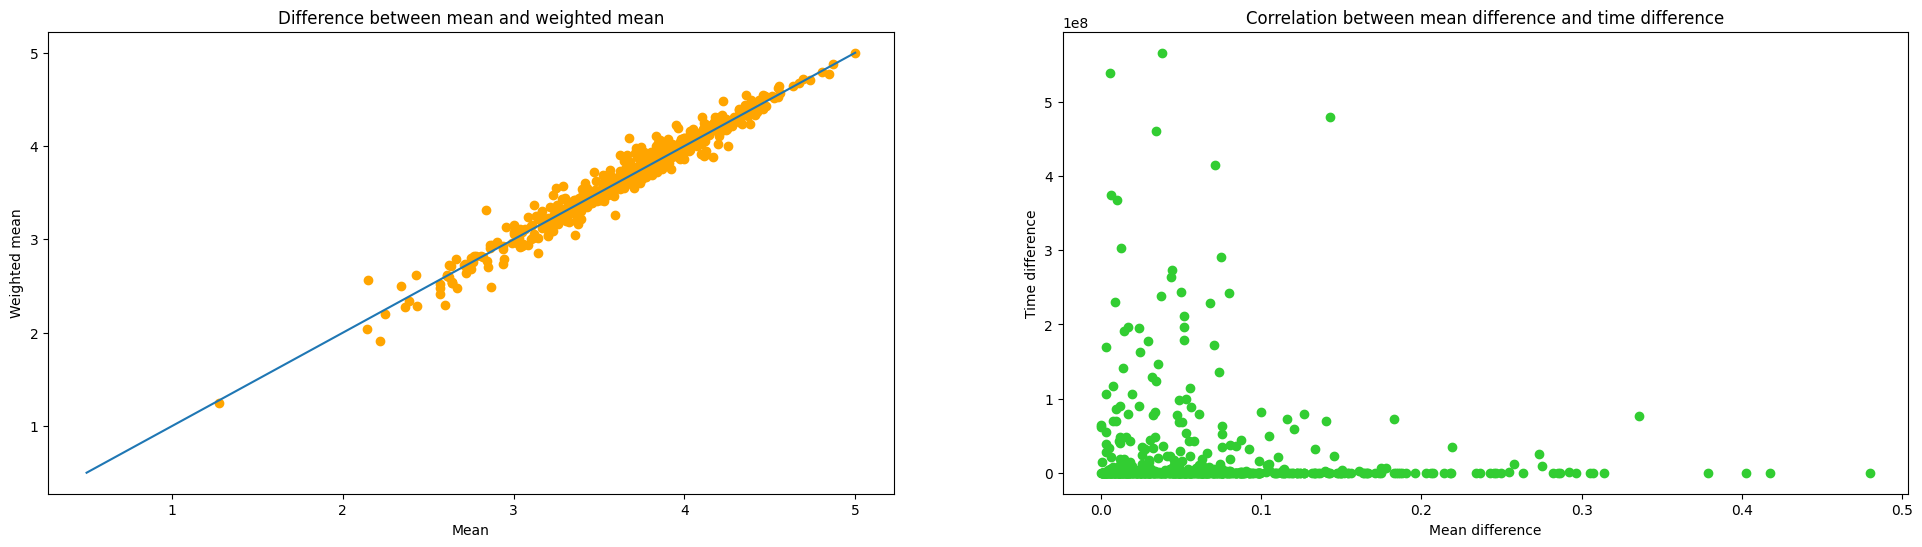

In [34]:
from matplotlib import pyplot as plt

(fig, axis) = plt.subplots(nrows = 1, ncols = 2, figsize=(24, 6))
axis[0].plot(users_dataset['mean'], users_dataset['weighted_mean'], 'o', color = 'orange')
axis[0].plot([0.5, 5.0], [0.5, 5.0], '-', color = 'tab:blue')
axis[0].set_title('Difference between mean and weighted mean')
axis[0].set_xlabel('Mean')
axis[0].set_ylabel('Weighted mean')
axis[1].plot(users_dataset['mean_diff'], users_dataset['time_diff'], 'o', color = 'limegreen')
axis[1].set_title('Correlation between mean difference and time difference')
axis[1].set_xlabel('Mean difference')
axis[1].set_ylabel('Time difference')

Da una analisi del terzo grafico, notiamo che la maggior parte dei punti sono molto vicini alla retta `y = x`, che rappresenta l'uguaglianza fra i due valori.  
Inoltre, notiamo che molti punti sono posizionati sopra la retta. Quindi, come hanno mostrato i primi due grafici, la media pesata è maggiore della media aritmetica per un buon numero di utenti.

Analizzando invece il quarto grafico, notiamo che i punti sono distribuiti principalmente nella parte bassa del grafico.  
Questo ci permette di affermare che non è detto che all'aumentare della differenza fra le due medie, aumenti anche la differenza fra i timestamp.

## Predizioni dei rating con sistemi integrati in `surprise`

Iniziamo la creazione ed il test dei sistemi di raccomandazione forniti dalla libreria `surprise`.  
Per iniziare, occorre prendere il data set e suddividerlo in due parti:
- **Training set**, un sottoinsieme del data set utilizzato per addestrare il sistema di raccomandazione. Su questi dati, l'algoritmo cerca di creare un modello che permetta di predire i rating degli utenti.
- **Test set**, un sottoinsieme del data set utilizzato per testare il sistema di raccomandazione. Su questi dati, l'algoritmo cerca di predire i rating degli utenti utilizzando il modello creato con il training set. I rating predetti vengono poi confrontati con i rating reali per calcolare le performance del sistema di raccomandazione.

Per poter suddividere il data set, possiamo utilizzare due metodi differenti:
- **Split**, implica la suddivisione del dataset in due parti, una per il training e l'altra per il testing. Nel nostro caso, il training set contiene l'80% del dataset mentre il test set contiene il restante 20%. Questa tecnica è semplice e veloce da implementare, tuttavia, una suddivisione non accurata (ad esempio, non tenendo conto del bilanciamento del dataset) può influenzare negativamente le performance del sistema di raccomandazione. La libreria `surprise` fornisce un metodo per effettuare lo split del dataset, chiamato `train_test_split()`.
- **Cross Validation**, prevede di suddividere il dataset in `k` parti uguali, chiamate fold (da qui il nome `k-fold`). Il modello viene poi addestrato su `k-1` fold e testato sul fold rimanente. Questo processo viene ripetuto k volte, utilizzando un fold differente come test set ad ogni ripetizione. In questo modo, ogni osservazione viene utilizzata sia per il training che per il testing. Questa tecnica può essere utile per valutare il modello in modo più accurato, riducendo l'effetto della scelta casuale dei dati di training e testing ottenuti con un semplice split. La libreria `surprise` fornisce una classe, chiamata `KFold`, che permette di effettuare la cross validation.

Una volta addestrato e testato il sistema di raccomandazione, possiamo calcolare le sue performance utilizzando le seguenti metriche:
- **RMSE** (Root Mean Squared Error), misura l'errore medio del sistema di raccomandazione, che viene calcolata come la radice quadrata della media dei quadrati delle differenze tra le valutazioni previste e quelle effettive degli utenti.  
La sua formula è:
$$
RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y_i})^2}
$$
- **MSE** (Mean Squared Error), misura l'errore medio del sistema di raccomandazione, che viene calcolata come la media dei quadrati delle differenze tra le valutazioni previste e quelle effettive degli utenti.  
La sua formula è:
$$
MSE = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y_i})^2
$$
- **MAE** (Mean Absolute Error), misura l'errore medio del sistema di raccomandazione, che viene calcolata come la media dei valori assoluti delle differenze tra le valutazioni previste e quelle effettive degli utenti.   
La sua formula è:
$$
MAE = \frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y_i}|
$$

Creiamo una funzione chiamata `test_algorithm()` che ci permette di addestrare, testare e calcolare le performance di un sistema di raccomandazione.
Creiamo anche una funzione chiamata `format_results()` che ci permette di formattare i risultati ottenuti dalla funzione `test_algorithm()`, in modo da poterli organizzare in un data frame.

In [35]:
from surprise import AlgoBase, Trainset, accuracy
from surprise.model_selection import KFold, train_test_split


def test_algorithm(algorithm: AlgoBase) -> tuple[dict[str, float], dict[str, np.ndarray]]:
    train, test = train_test_split(elaborated_data, test_size=0.2)
    algorithm.fit(train)
    split_predictions = algorithm.test(test)
    split_predictions_measure = dict[str, float]()
    split_predictions_measure['rmse'] = accuracy.rmse(split_predictions, verbose=False)
    split_predictions_measure['mae'] = accuracy.mae(split_predictions, verbose=False)
    split_predictions_measure['mse'] = accuracy.mse(split_predictions, verbose=False)
    
    kf = KFold(n_splits=5)
    cross_predictions_measure = dict[str, np.ndarray]()
    cross_predictions_measure['rmse'] = np.array([])
    cross_predictions_measure['mae'] = np.array([])
    cross_predictions_measure['mse'] = np.array([])
    for k_train, k_test in kf.split(elaborated_data):
        algorithm.fit(k_train)
        k_predictions = algorithm.test(k_test)
        cross_predictions_measure['rmse'] = np.append(cross_predictions_measure['rmse'], accuracy.rmse(k_predictions, verbose=False))
        cross_predictions_measure['mae'] = np.append(cross_predictions_measure['mae'], accuracy.mae(k_predictions, verbose=False))
        cross_predictions_measure['mse'] = np.append(cross_predictions_measure['mse'], accuracy.mse(k_predictions, verbose=False))
    
    return (split_predictions_measure, cross_predictions_measure)

def format_results(algo_name: str, results: tuple[dict[str, float], dict[str, np.ndarray]]) -> pd.DataFrame:
    return pd.DataFrame({
        'Split RMSE': results[0]['rmse'], 
        'Split MAE': results[0]['mae'], 
        'Split MSE': results[0]['mse'], 
        'Cross RMSE': results[1]['rmse'].mean(), 
        'Cross MAE': results[1]['mae'].mean(), 
        'Cross MSE': results[1]['mse'].mean()
    }, index=[algo_name])

Creiamo una lista di `AlgoBase` (la classe con cui la libreria costruisce tutti i sistemi), chiamata `algorithms`, che contiene i seguenti algoritmi:

In [36]:
algorithms: list[AlgoBase] = []

#### NormalPredictor
Il predittore normale è un semplice algoritmo di raccomandazione che restituisce una valutazione casuale, calcolata dalla distribuzione dei dati del training set.  
Questo algoritmo stima i parametri della distribuzione normale (cioè media e varianza) basandosi sul [metodo della massima verosimiglianza](https://it.wikipedia.org/wiki/Metodo_della_massima_verosimiglianza).  
Affinché questo funzioni correttamente, è necessario che il dataset sia distribuito normalmente secondo la colonna `rating`.  
Per verificare questa ipotesi, utilizziamo il test di [Shapiro-Wilk](https://it.wikipedia.org/wiki/Test_di_Shapiro-Wilk), fornitoci dalla libreria `scipy`. 
Utilizziamo il secondo parametro restituito, rappresentante il p-value, per verificare se i dati sono normalmente distribuiti. Ciò significa il p-value deve essere maggiore di 0.05. 

Poiché il test funziona al meglio con un massimo di 5000 valori, utilizziamo la tecnica di **bootstrap** per creare diversi sample di 5000 elementi ciascuno. Questa tecnica di split ci permette di mantenere la distribuzione dei dati, ma di ridurre la dimensione del dataset. Nel nostro caso, creiamo 50 sample da 5000 elementi ciascuno. Se i sample che seguono la distribuzione normale sono maggiori di quelli che non la seguono, possiamo dire che il dataset è distribuito normalmente secondo la colonna `rating`. 

In [37]:
from scipy.stats import shapiro
from surprise.prediction_algorithms import NormalPredictor

data = np.array(rating_dataset['rating'].tolist())
n_bootstraps = 50
bootstrap_samples_size = 5000
samples = np.random.choice(data, size=(n_bootstraps, bootstrap_samples_size), replace=True)
positive_samples = 0
negative_samples = 0

for sample in samples:
    stat, p = shapiro(sample)
    alpha = 0.05
    if p > alpha:
        positive_samples += 1
    else:
        negative_samples += 1
        
if positive_samples > negative_samples:
    print('I dati sono normalmente distribuiti')
    algorithms.append(NormalPredictor())
else:
    print('I dati non sono normalmente distribuiti')

I dati non sono normalmente distribuiti


Poiché i dati non sono normalmente distribuiti, non possiamo utilizzare questo algoritmo.

#### Predittori basati sulla fattorizzazione della matrice
La fattorizzazione di una matrice è una tecnica matematica che permette di rappresentare una matrice come prodotto di altre matrici più semplici.  
Fra i sistemi di raccomandazione che implementano questa tecnica, abbiamo:
- **SVD** (Singular Value Decomposition), ci permette di scomporre una matrice $A$ in tre parti: una matrice unitaria di sinistra $U$, una matrice diagonale di valori singolari $\Sigma$ e una matrice unitaria di destra $V$. I valori singolari rappresentano l'importanza relativa di ciascuna delle colonne di $U$ e di $V$ nella rappresentazione della matrice originale $A$.
- **SVD++** (Singular Value Decomposition Plus Plus), una variante dell'algoritmo SVD, presentata da Simon Funk durante il concorso di Netflix. Questo algoritmo tiene conto anche di altre informazioni esterne alle valutazioni (cronologia visualizzazioni, popolarità fra gli utenti) per migliorare le performance del sistema di raccomandazione.
- **NMF** (Non-negative Matrix Factorization), ci permette di scomporre una matrice $A$ in due matrici $W$ e $H$, in modo che il prodotto di queste due matrici sia il più simile possibile alla matrice originale $A$. Questo algoritmo è molto simile a SVD, tuttavia, le matrici $W$ e $H$ conterranno solo valori positivi. 

In [38]:
from surprise.prediction_algorithms import NMF, SVD, SVDpp

algorithms.extend([SVD(), SVDpp(), NMF()])

#### Predittori basati su KNN
Gli algoritmi basati su KNN (K-Nearest Neighbors) sono algoritmi che stimano il rating basandosi sui k utenti (o item) più simili all'utente (o item) di cui si vuole stimare il rating.  
Esistono diverse varianti che normalizzano i rating in modo diverso:
- **KNNBasic**, i rating non sono normalizzati
- **KNNWithMeans**, i rating sono normalizzati sottraendo la media degli utenti (o item)
- **KNNWithZScore**, i rating sono normalizzati sottraendo la media degli utenti (o item) e dividendo per la deviazione standard
- **KNNBaseline**, i rating sono normalizzati sottraendo un termine di baseline

In [39]:
from surprise import KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore

algorithms.extend([KNNBaseline(k=40, verbose=False), KNNBasic(k=40, verbose=False), KNNWithMeans(k=40, verbose=False), KNNWithZScore(k=40, verbose=False)])

#### Altri predittori
Altri predittori degni di nota sono:
- **SlopeOne**, è un algoritmo di raccomandazione collaborativo che si basa sulle differenze medie tra le valutazioni degli utenti. Ad esempio, se un utente U ha valutato l'oggetto A con una valutazione di 4 e la differenza media tra l'item A e l'item C è di 2, allora l'algoritmo assegna all'item C, per l'utente U, una valutazione di 6.
- **CoClustering**, è un algoritmo di clustering collaborativo, dove utenti ed item sono raggruppati in cluster cercando di massimizzare la similarità tra gli utenti e gli item.

In [40]:
from surprise.prediction_algorithms import CoClustering, SlopeOne

algorithms.extend([SlopeOne(), CoClustering()])

Dopo aver creato la lista di algoritmi, creiamo un data frame, chiamato `results`, che conterrà i risultati di tutti gli algoritmi.  
Eseguiamo ogni algoritmo con la funzione creata prima e salviamo i risultati nel data frame.

In [41]:
algorithms_results = pd.DataFrame(columns=['Split RMSE', 'Split MAE', 'Split MSE', 'Cross RMSE', 'Cross MAE', 'Cross MSE'])
algorithms_results.index.name = 'Algorithm Name'

for algo in algorithms:
    split_result, cross_result = test_algorithm(algo)
    result_df = format_results(algo.__class__.__name__, (split_result, cross_result))
    algorithms_results = pd.concat([algorithms_results, result_df])
    algorithms_results.index.name = 'Algorithm Name'
    
algorithms_results

,Split RMSE,Split MAE,Split MSE,Cross RMSE,Cross MAE,Cross MSE
Algorithm Name,,,,,,
SVD,0.869422,0.666533,0.755895,0.873011,0.671075,0.762153
SVDpp,0.858112,0.656350,0.736356,0.862303,0.660662,0.743604
NMF,0.921305,0.706172,0.848802,0.920758,0.705592,0.847812
KNNBaseline,0.878780,0.670934,0.772254,0.874875,0.668700,0.765444
KNNBasic,0.938419,0.719191,0.880631,0.948046,0.726408,0.898821
KNNWithMeans,0.902432,0.691285,0.814384,0.896402,0.684675,0.803577
KNNWithZScore,0.896091,0.679801,0.802980,0.896227,0.679815,0.803279
SlopeOne,0.894890,0.686221,0.800828,0.901374,0.688709,0.812481
CoClustering,0.948706,0.732839,0.900044,0.947938,0.733683,0.898603


## Predizione dei rating con media pesata

Una possibile variante del sistema `KNNWithMeans` è quella di normalizzare i rating utilizzando una media pesata delle valutazioni (utilizzando i timestamp come pesi) invece della media aritmetica. 

Per creare una sistema di raccomandazione personalizzato, `surprise` ci permette di creare delle nuove classi che ereditano da quelle già esistenti.  
Creiamo una nuova classe chiamata `KNNWithMeansWeighted` che eredita dalla classe `KNNWithMeans` e sovrascrive il metodo `fit()`. All'interno del metodo vengono infatti effettuati i calcoli per trovare la media delle valutazioni per utenti.  
Per una limitazione della libreria (i timestamp non vengono presi in considerazione nella creazione dei dataset), non è possibile fare il calcolo direttamente all'interno del metodo, ma possiamo utilizzare l'id utente per poter accedere al data frame degli utenti e recuperare la media pesata che abbiamo calcolato in precedenza.

In [42]:
class KNNWithWeightedMeans(KNNWithMeans):
    def __init__(self, k=40, min_k=1, sim_options={}, verbose=False):
        super().__init__(k, min_k, sim_options, verbose)
        
    __name__ = 'KNNWithWeightedMeans'
        
    def fit(self, trainset: Trainset):
        super().fit(trainset)
        self.means = np.zeros(self.n_x)
        for x, _ in self.xr.items():
            user_id = trainset.to_raw_uid(x)
            weighted_mean = users_dataset.loc[user_id]['weighted_mean']
            self.means[x] = weighted_mean

Una volta creata la classe, possiamo utilizzarla come qualsiasi altro predittore.

In [43]:
algo = KNNWithWeightedMeans(k=40, verbose=False)
split_result, cross_result = test_algorithm(algo)
result_df = format_results(algo.__class__.__name__, (split_result, cross_result))
algorithms_results = pd.concat([algorithms_results, result_df])
algorithms_results.index.name = 'Algorithm Name'

algorithms_results

,Split RMSE,Split MAE,Split MSE,Cross RMSE,Cross MAE,Cross MSE
Algorithm Name,,,,,,
SVD,0.869422,0.666533,0.755895,0.873011,0.671075,0.762153
SVDpp,0.858112,0.656350,0.736356,0.862303,0.660662,0.743604
NMF,0.921305,0.706172,0.848802,0.920758,0.705592,0.847812
KNNBaseline,0.878780,0.670934,0.772254,0.874875,0.668700,0.765444
KNNBasic,0.938419,0.719191,0.880631,0.948046,0.726408,0.898821
KNNWithMeans,0.902432,0.691285,0.814384,0.896402,0.684675,0.803577
KNNWithZScore,0.896091,0.679801,0.802980,0.896227,0.679815,0.803279
SlopeOne,0.894890,0.686221,0.800828,0.901374,0.688709,0.812481
CoClustering,0.948706,0.732839,0.900044,0.947938,0.733683,0.898603


## Predizione binaria

I sistemi di raccomandazione sono in grado di lavorare anche con rating binari, dove i valori sono:
- `0`, se l'utente non gradisce l'item
- `1`, se l'utente gradisce l'item

Per poter utilizzare un predittore binario, dobbiamo convertire i rating reali in rating binari.  
Utilizzeremo una soglia, chiamata `binary_threshold`, calcolata attraverso la media delle valutazioni dei rating reali.  
Copiamo il data frame delle valutazioni in un nuovo data frame, chiamato `binarized_df`, e applichiamo, sulla colonna delle valutazioni, una funzione lambda che restituisce `1` se il rating è maggiore o uguale alla soglia, altrimenti restituisce `0`.

In [44]:
binary_threshold = np.mean(rating_dataset['rating'].tolist())
binarized_df = rating_dataset.copy()
binarized_df['rating'] = binarized_df['rating'].apply(lambda x: 1 if x >= binary_threshold else 0)

binarized_data = Dataset.load_from_df(binarized_df[['userId', 'movieId', 'rating']], reader=Reader(rating_scale=(0, 1)))

Nella predizione binaria, cambiano anche le metriche di valutazione:
- **TP** (True Positive), numero di rating positivi predetti correttamente
- **TN** (True Negative), numero di rating negativi predetti correttamente
- **FP** (False Positive), numero di rating negativi predetti erroneamente
- **FN** (False Negative), numero di rating positivi predetti erroneamente

A partire da questo quattro metriche, possiamo calcolare altre metriche come:
- **Accuracy**, percentuale di rating predetti correttamente
- **Precision**, percentuale di rating positivi predetti correttamente
- **Recall**, percentuale di rating positivi predetti correttamente rispetto al numero di rating positivi reali

In [45]:
from surprise import Prediction

def tp(predictions: list[Prediction]) -> int:
    return len([1 for p in predictions if p.est == p.r_ui and p.r_ui == 1])
    
def tn(predictions: list[Prediction]) -> int:
    return len([1 for p in predictions if p.est == p.r_ui and p.r_ui == 0])

def fp(predictions: list[Prediction]) -> int:
    return len([1 for p in predictions if p.est != p.r_ui and p.r_ui == 0])

def fn(predictions: list[Prediction]) -> int:
    return len([1 for p in predictions if p.est != p.r_ui and p.r_ui == 1])

Occorre anche creare un predittore binario poiché la libreria `surprise` non lo fornisce.  
È importante ricordare che i predittori binari seguono logiche diverse rispetto ai predittori reali.    
La prima cosa che cambia è il calcolo della similarità fra utenti. La misura utilizzata infatti sarà la similarità di Jaccard, definita come:
$$
J(A,B) = \frac{|A \cap B|}{|A \cup B|}
$$
dove $A$ e $B$ sono due insiemi. Questa misura corrisponde alla percentuale di elementi in comune fra i due insiemi rispetto al numero totale di elementi.  
Per questo motivo, la funzione `compute_similarities()` viene sovrascritta e viene calcolata la similarità di Jaccard fra gli utenti.  
Inoltre, i sistemi binari restituiscono predizioni dove i valori sono solamente due, cioè:
- `0`, se è più probabile che l'utente non gradisca l'item
- `1`, se è più probabile che l'utente gradisca l'item

Per questo motivo, la funzione `estimate()` viene sovrascritta e restituisce la mediana fra tutti i rating, in modo che venga restituito quale fra i valori `0` e `1` compare più spesso.

In [46]:
class BinaryPredictor(AlgoBase):
    
    __name__ = 'BinaryPredictor'
    
    def fit(self, trainset):
        super().fit(trainset)
        self.sim = self.compute_similarities()
    
    def estimate(self, u, i):
        neighbors = self.get_neighbors(u, i)
        if len(neighbors) == 0:
            return 0
        else:
            return np.median([r for (_, _, r) in neighbors])
            
    # Compute Jaccard similarity between users u and v
    def similarity(self, u, v):
        u_items = set([i for (i, _) in self.trainset.ur[u]])
        v_items = set([i for (i, _) in self.trainset.ur[v]])
        
        union = u_items.union(v_items)
        intersection = u_items.intersection(v_items)
        
        return len(intersection) / len(union)
            
    # Compute all similarities between users
    def compute_similarities(self):
        sim = np.zeros((self.trainset.n_users, self.trainset.n_users), np.double)
        for u in range(self.trainset.n_users):
            for v in range(self.trainset.n_users):
                sim[u, v] = self.similarity(u, v)
        return sim
    
    # Get the k-nearest neighbors of user u that have rated item i
    def get_neighbors(self, u, i):
        neighbors = [(u2, self.sim[u, u2], r) for (u2, r) in self.trainset.ir[i]]
        neighbors = sorted(neighbors, key=lambda x: x[1], reverse=True)
        return [(v, sim_uv, r) for (v, sim_uv, r) in neighbors[:40] if sim_uv > 0.5]

Una volta creato il predittore binario e le metriche di valutazione, possiamo creare una funzione che lo esegue e calcola le metriche di valutazione, chiamata `test_binary_algorithm()`. Essa è molto simile alla funzione `test_algorithm()` creata in precedenza, ma utilizza il il dataset binario e le metriche di valutazione binarie.  
Inoltre, creiamo anche una funzione `format_binary_results()` che formatta i risultati ottenuti in modo da poterli stampare in modo più leggibile.

In [47]:
def test_binary_algorithm(algorithm: AlgoBase) -> tuple[dict[str, float], dict[str, np.ndarray]]:
    train, test = train_test_split(binarized_data, test_size=0.2)
    algorithm.fit(train)
    split_predictions = algorithm.test(test)
    split_predictions_measure = dict[str, float]()
    split_predictions_measure['tp'] = tp(split_predictions)
    split_predictions_measure['tn'] = tn(split_predictions)
    split_predictions_measure['fp'] = fp(split_predictions)
    split_predictions_measure['fn'] = fn(split_predictions)
    
    kf = KFold(n_splits=5)
    cross_predictions_measure = dict[str, np.ndarray]()
    cross_predictions_measure['tp'] = np.array([])
    cross_predictions_measure['tn'] = np.array([])
    cross_predictions_measure['fp'] = np.array([])
    cross_predictions_measure['fn'] = np.array([])
    for k_train, k_test in kf.split(binarized_data):
        algorithm.fit(k_train)
        k_predictions = algorithm.test(k_test)
        cross_predictions_measure['tp'] = np.append(cross_predictions_measure['tp'], tp(k_predictions))
        cross_predictions_measure['tn'] = np.append(cross_predictions_measure['tn'], tn(k_predictions))
        cross_predictions_measure['fp'] = np.append(cross_predictions_measure['fp'], fp(k_predictions))
        cross_predictions_measure['fn'] = np.append(cross_predictions_measure['fn'], fn(k_predictions))
    
    return (split_predictions_measure, cross_predictions_measure)

def format_binary_results(algo_name: str, results: tuple[dict[str, float], dict[str, np.ndarray]]) -> pd.DataFrame:
    df = pd.DataFrame({
        'Split TP': results[0]['tp'], 
        'Split TN': results[0]['tn'], 
        'Split FP': results[0]['fp'], 
        'Split FN': results[0]['fn'], 
        'Cross TP': results[1]['tp'].mean(), 
        'Cross TN': results[1]['tn'].mean(), 
        'Cross FP': results[1]['fp'].mean(),
        'Cross FN': results[1]['fn'].mean(),
        'Split Accuracy': (results[0]['tp'] + results[0]['tn']) / (results[0]['tp'] + results[0]['tn'] + results[0]['fp'] + results[0]['fn']),
        'Cross Accuracy': (results[1]['tp'].mean() + results[1]['tn'].mean()) / (results[1]['tp'].mean() + results[1]['tn'].mean() + results[1]['fp'].mean() + results[1]['fn'].mean()),
        'Split Precision': results[0]['tp'] / (results[0]['tp'] + results[0]['fp']),
        'Cross Precision': results[1]['tp'].mean() / (results[1]['tp'].mean() + results[1]['fp'].mean()),
        'Split Recall': results[0]['tp'] / (results[0]['tp'] + results[0]['fn']),
        'Cross Recall': results[1]['tp'].mean() / (results[1]['tp'].mean() + results[1]['fn'].mean()),
    }, index=[algo_name])
    df.index.name = 'Algorithm Name'
    return df

Creato tutto, possiamo eseguire il predittore binario e calcolare le metriche di valutazione.

In [48]:
algo = BinaryPredictor()
split_result, cross_result = test_binary_algorithm(algo)
result_df = format_binary_results(algo.__class__.__name__, (split_result, cross_result))

result_df

,Split TP,Split TN,Split FP,Split FN,Cross TP,Cross TN,Cross FP,Cross FN,Split Accuracy,Cross Accuracy,Split Precision,Cross Precision,Split Recall,Cross Recall
Algorithm Name,,,,,,,,,,,,,,
BinaryPredictor,5,10383,6,9774,3.8,10447.2,4.0,9712.2,0.515073,0.518218,0.454545,0.487179,0.000511,0.000391


## Conclusioni

Analizzando tutti i predittori, notiamo che le misure di performance per i predittori basati su valori reali si aggirano tutti intorno allo stesso valore. Questo perché, nonostante gli algoritmi effettuino calcoli diversi per predirre le valutazioni, la grandezza del dataset minimizza le differenze fra di essi.  

Analizzando la prima variante presentata, ovvero il predittore basato sulla media pesata, notiamo che le performance sono leggermente migliori rispetto al predittore basato sulla media aritmetica. Tuttavia, come visto nella sezione relativa all'analisi dei dati, la media pesata e la media aritmetica differiscono di poco per ogni utente. Questo significa che non sarà possibile ottenere performance molto distanti da quelle ottenute utilizzando il predittore basato la media aritmetica.

Analizzando la seconda variante, ovvero il predittore binario, notiamo che le sue performance sono molto basse. La conversione dei rating reali in rating binari ha portato a perdere molte informazioni, ovvero tutti i valori intermedi, rendendo il predittore meno accurato.